In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Optional

Clear output to get new `.h5` model

In [3]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

## Import tools

Import tools and instance a variable path, batch, and image size.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda, BatchNormalization
from tensorflow.keras.regularizers import l2
import os
from sklearn.model_selection import train_test_split
import numpy as np           
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import FileLink
from PIL import Image

In [5]:
base_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

## Preprocessing

This function use to resize and normalize input image.

In [6]:
def prep_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

## Get data path

Get data path by using this function `get_dataset_path`:
This function allow us to get the direct data of image in file using data path.

In [7]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = Image.open(file_path)
            if img.format in ['JPEG', 'JPG', 'PNG', 'GIF', 'BMP']:
                file_paths.append(file_path)
                labels.append(i) # Label with integer

    return file_paths, labels, classes

In [8]:
file_paths, labels, class_names = get_dataset_path(base_path)

print(f"Found {len(file_paths)} images in {len(class_names)} classes.")

Found 19398 images in 10 classes.


The labels here use numbers that represent each class: <br>
| Label | Class      |
|-------|------------|
| 0     | battery    |
| 1     | biological |
| 2     | cardboard  |
| 3     | clothes    |
| 4     | glass      |
| 5     | metal      |
| 6     | paper      |
| 7     | plastic    |
| 8     | shoes      |
| 9     | trash      |


## Split data

Split the data to 80% `train`, 10% `test`, and 10% `validation`.
* First we get all the data from the `file_paths` and send 20% to test.
* Then, we get a half of test and assign it to val.

In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42
)

## Create dataset

Using `tf.data.Dataset.from_tensor_slices((file_paths, labels))` to create a dataset and then `map` the `prep_image` function to do preprocessing image. So we can finally shuffle and batch.

In [10]:
def create_dataset(file_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(prep_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [11]:
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)
val_dataset = create_dataset(val_paths, val_labels)

Image shape: (32, 224, 224, 3)
Label: [1 3 1 8 0 3 6 3 3 3 2 4 8 8 4 3 3 3 1 7 8 4 3 7 7 0 4 3 3 8 3 3]


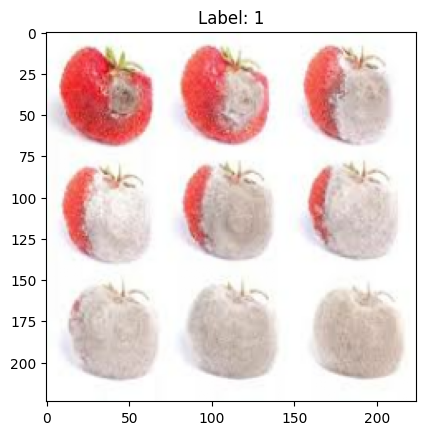

In [12]:
for image, label in train_dataset.take(1):
        print("Image shape:", image.shape)
        print("Label:", label.numpy())
        plt.imshow(image[0].numpy())
        plt.title(f"Label: {label.numpy()[0]}")
        plt.show

## Augmentation

Augment train dataset to get more various image

In [13]:
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.random_hue(img, max_delta=0.1)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

## Build model

We will build a model using `MobileNetV2`, a popular convolutional neural network architecture known for its efficiency and accuracy. For our specific use case, we will keep the last 70 layers of the model trainable to allow for fine-tuning, which will help us adapt the pre-trained features to our specific dataset. After setting up the layers, we will compile the model using the `Adam` optimizer.

In [14]:
def build_model(num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    
    for layer in base_model.layers[-70:]:
        layer.trainable = True
        
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        # Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        # Lambda(lambda x: x * 1.0),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),  
        Dense(num_classes, activation='softmax')  
    ])
    
    return model

In [15]:
tf.keras.backend.clear_session()

num_classes = len(class_names)
model = build_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr= 1e-6)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train

Next step is to train it using the training dataset, ensuring that the model learns the underlying patterns and features of the data. Once the training process is complete, we will evaluate the model's performance using the `test_dataset`. This evaluation will help us understand how well the model generalizes to new, unseen data

In [18]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


I0000 00:00:1732254749.872975      71 service.cc:145] XLA service 0x7f5b4405d480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732254749.873042      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732254749.873048      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/485 ━━━━━━━━━━━━━━━━━━━━ 6:20:59 47s/step - accuracy: 0.1562 - loss: 3.1449

I0000 00:00:1732254774.623383      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


485/485 ━━━━━━━━━━━━━━━━━━━━ 135s 181ms/step - accuracy: 0.2256 - loss: 2.9109 - val_accuracy: 0.6031 - val_loss: 1.2362 - learning_rate: 1.0000e-05
Epoch 2/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.5746 - loss: 1.4210 - val_accuracy: 0.7773 - val_loss: 0.7227 - learning_rate: 1.0000e-05
Epoch 3/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.6970 - loss: 1.0189 - val_accuracy: 0.8448 - val_loss: 0.5146 - learning_rate: 1.0000e-05
Epoch 4/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.7570 - loss: 0.7868 - val_accuracy: 0.8768 - val_loss: 0.4202 - learning_rate: 1.0000e-05
Epoch 5/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.8010 - loss: 0.6746 - val_accuracy: 0.8907 - val_loss: 0.3727 - learning_rate: 1.0000e-05
Epoch 6/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.8319 - loss: 0.5701 - val_accuracy: 0.9021 - val_loss: 0.3318 - learning_rate: 1.0000e-05
Epoch 7/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step -

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9260 - loss: 0.2523
Test Accuracy: 93.09%


## Plot training

Plot the training and validation loss and accuracy metrics from the history object to visualize the model’s performance.

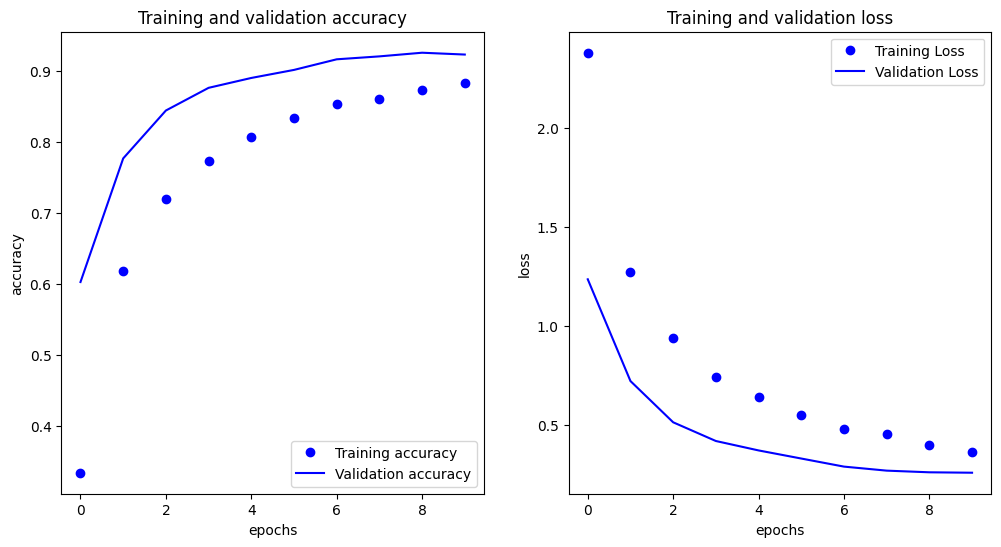

In [20]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

## Convert model

Convert the model to JSON format to ensure compatibility and ease of deployment across different platforms and applications.

In [21]:
file_path = "/kaggle/working/model_fixed.h5"
display(FileLink(file_path))

/kaggle/working/model_fixed.h5

In [22]:
model.save(file_path)

In [23]:
tf.saved_model.save(model, '/kaggle/working/tf_model')

In [25]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /kaggle/working/tf_model/ /kaggle/working/tfjs_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is

Convert an `.h5` model to JSON for the model to run on a server.

In [26]:
# !pip install tensorflowjs

# !tensorflowjs_converter --input_format=keras {file_path} ./converted_model

## References
@misc{suman_kunwar_2024,
   title={Garbage Dataset},
   url={https://www.kaggle.com/dsv/8984984},
   DOI={10.34740/KAGGLE/DSV/8984984},
   publisher={Kaggle},
   author={Suman Kunwar},
   year={024}
}
024}
}
024}
}
